# Accessibility to grocery stores from LTD bus stops in Eugene

In [1]:
import numpy as np 
import geopandas as gpd
import osmnx as ox
import networkx as nx
import os 
os.environ['USE_PYGEOS'] = '0' 
import matplotlib.pyplot as plt 
import folium
from shapely.geometry import Point, LineString, Polygon, MultiPolygon 
from descartes import PolygonPatch

## Data

In [2]:
cd downloads

/Users/annajatsura/Downloads


In [40]:
grocery_stores = gpd.read_file('GroceryStores/GroceryStores.shp')

In [70]:
ltd_stops = gpd.read_file('EMX_and_LTD/LTD_Stops_Fall_2019.shp')

## Grocery Stores

In [41]:
grocery_stores.crs

<Derived Projected CRS: EPSG:2914>
Name: NAD83(HARN) / Oregon South (ft)
Axis Info [cartesian]:
- [east]: Easting (foot)
- [north]: Northing (foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [42]:
grocery_stores_reproject = grocery_stores.to_crs('EPSG:32610')
grocery_stores_reproject.crs

<Derived Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [43]:
grocery_stores_reproject

OBJECTID  geofeat_id                     concat_add  house_nbr  \
0          81       12201                   14638 HWY 36      14638   
1         214      146666                   13298 HWY 36      13298   
2         399      112346                  10876 HWY 126      10876   
3        1163      146620                   12373 HWY 36      12373   
4        1913       99816                  87764 HWY 101      87764   
5        2581      146691                   13987 HWY 36      13987   
6        3287       99900                  88940 HWY 101      88940   
7        3670      112435                   11752 HWY 36      11752   
8        5034      104764                    1560 9TH ST       1560   
9        5107      100034                   1750 HWY 126       1750   
10       5418      105108                   1709 16TH ST       1709   
11       6088       99283                    700 HWY 101        700   
12       6881      100071                   6750 HWY 126       6750   
13       7285       99344                   2066 HWY 101       2066   
14       7293       99345                   2076 HWY 101       2076   
15       7294     1012349                   2086 HWY 101       2086   
16       7639       99677                  85150 HWY 101      85150   
17       7926      102031         1379 RHODODENDRON DR B       1379   
18       8260      151041                 6937 CANARY RD       6937   
19       9543      105976              90828 RAILROAD ST      90828   
20      10542       98102                    1352 BAY ST       1352   
21      10726       28457          27359 CLEAR LAKE RD 1      27359   
22      11660       14270          88706 TERRITORIAL HWY      88706   
23      11782       99652                  85039 HWY 101      85039   
24      12240      147854                  25013 HWY 126      25013   
25      12304      113865                  22528 NOTI LP      22528   
26      12854      149189           88198 TERRITORIAL RD      88198   
27      13412      149181           88114 TERRITORIAL RD      88114   
28      14609      148970           87754 TERRITORIAL RD      87754   
29      14895      147859                  25101 HWY 126      25101   
30      14915      147869                25547 HWY 126 1      25547   
31      14947      147897                  25929 HWY 126      25929   
32      15540      148841          86065 TERRITORIAL HWY      86065   
33      16169      107709                    1755 IVY ST       1755   
34      16229      107700                    1610 IVY ST       1610   
35      16557      107428                  95400 HWY 99E      95400   
36      17255      107609                     500 IVY ST        500   
37      17271      106919               510 GREENWOOD ST        510   
38      18944      107633                     787 IVY ST        787   
39      19060         245                   20448 HWY 36      20448   
40      19609        1263              93190 LONG TOM DR      93190   
41      20040         163                   19316 HWY 36      19316   
42      20105      109344                 92573 RIVER RD      92573   
43      20213      109821          91979 TERRITORIAL HWY      91979   
44      21225        1737          91145 N WILLAMETTE ST      91145   
45      24388     1000783               190 EMERALD PKWY        190   
46      24463       11632                    11 N 2ND ST         11   
47      24505       10598                   93 N MILL ST         93   
48      25133        9848                 115 S FRONT ST        115   
49      26306        4205                   79946 HWY 99      79946   
50      26328        4201                   79916 HWY 99      79916   
51      27775        8216                   633 N 9TH ST        633   
52      28254        6980                150 THORNTON LN        150   
53      28283        5069                 1500 E MAIN ST       1500   
54      28385        5042                  911 E MAIN ST        911   
55      28605        3915    

### Buffer - Grocery stores within 1 mile of the UO

In [50]:
uo_pd_df = pd.DataFrame({'lat': [-123.0726], 'long': [44.0448]})

In [49]:
uo

lat     long
0 -123.0726  44.0448

In [51]:
uo_gpd_gdf = gpd.GeoDataFrame(uo_pd_df, geometry = gpd.points_from_xy(uo_pd_df.lat, uo_pd_df.long))

In [52]:
uo_gpd_gdf

lat     long                     geometry
0 -123.0726  44.0448  POINT (-123.07260 44.04480)

In [56]:
uo_gpd_gdf = uo_gpd_gdf.set_crs('EPSG:4326')

In [57]:
uo_gpd_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [58]:
uo_gpd_gdf_reproject = uo_gpd_gdf.to_crs('EPSG:32610')
uo_gpd_gdf_reproject.crs

<Derived Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [59]:
uo_gpd_gdf_reproject['geometry'] = uo_gpd_gdf_reproject.geometry.buffer(4000)

In [60]:
uo_gpd_gdf_reproject

lat     long                                           geometry
0 -123.0726  44.0448  POLYGON ((498183.741 4876851.259, 498164.480 4...

In [65]:
uo_grocery = gpd.sjoin(grocery_stores_reproject, uo_gpd_gdf_reproject)

In [66]:
uo_grocery

OBJECTID  geofeat_id            concat_add  house_nbr  house_suff  \
93      66837       84933        1131 W 1ST AVE       1131         NaN   
94      67241       79712      357 VAN BUREN ST        357         NaN   
95      67268       22056        385 BLAIR BLVD        385         NaN   
96      68250       86330        1525 W 6TH AVE       1525         NaN   
97      68471       87204        1101 W 8TH AVE       1101         NaN   
100     69102       86676        1333 W 7TH AVE       1333         NaN   
104     70611       88212       1915 W 11TH AVE       1915         NaN   
105     70622       88204       1815 W 11TH AVE       1815         NaN   
107     73314       92612       1675 W 18TH AVE       1675         NaN   
111     82738       29049        1500 COBURG RD       1500         NaN   
112     82949       82589   2580 WILLAKENZIE RD       2580         NaN   
119     88757      126582        1191 HARLOW RD       1191         NaN   
121     91216       28802         445 COBURG RD        445         NaN   
122     91706       62856      85 OAKWAY CENTER         85         NaN   
124     93309       28777         311 COBURG RD        311         NaN   
126     94054       28768         201 COBURG RD        201         NaN   
128     95874     1004672        117 COMMONS DR        117         NaN   
131     96001       59895         111 MONROE ST        111         NaN   
132     98547      129892            701 W M ST        701         NaN   
135    101075       86134         951 W 6TH AVE        951         NaN   
137    102829       86437       544 W 7TH AVE 1        544         NaN   
139    103346       86129         849 W 6TH AVE        849         NaN   
140    104308       86439         588 W 7TH AVE        588         NaN   
141    104528       23706       99 W BROADWAY C         99         NaN   
142    105349       23709        110 W BROADWAY        110         NaN   
143    105573      122835               30 E ST         30         NaN   
144    106462       87446         66 W 10TH AVE         66         NaN   
145    106944       87940        395 W 11TH AVE        395         NaN   
146    106947       87938        391 W 11TH AVE        391         NaN   
147    107985       87879        536 E 11TH AVE        536         NaN   
148    108280      118429              220 B ST        220         NaN   
149    109266       89419        410 W 13TH AVE        410         NaN   
150    109428       87918        125 W 11TH AVE        125         NaN   
151    109492       87862        503 E 11TH AVE        503         NaN   
152    109722       15834       1316 ALDER ST 1       1316         NaN   
153    109765       89258        544 E 13TH AVE        544         NaN   
154    110096       89194        296 E 13TH AVE        296         NaN   
155    110232       39025  2001 FRANKLIN BLVD 1       2001         NaN   
160    111958       39022    1960 FRANKLIN BLVD       1960         NaN   
164    113562       39147    4215 FRANKLIN BLVD       4215         NaN   
165    114202     1010163       1659 HILYARD ST       1659         NaN   
166    114587       39171    4430 FRANKLIN BLVD       4430         NaN   
167    114693       46731       1698 HILYARD ST       1698         NaN   
168    115581       92108        145 E 18TH AVE        145         NaN   
182    124546       92618       1690 W 18TH AVE       1690         NaN   
185    133832       39524    4791 FRANKLIN BLVD       4791         NaN   
186    134091       93417       1490 E 19TH AVE       1490         NaN   
187    135558       39525  4791 FRANKLIN BLVD 1       4791         NaN   
188    136817       83213    2489 WILLAMETTE ST       2489         NaN   
189    136962       15590         2390 AGATE ST       2390         NaN   
190    136978       94367        748 E 24TH AVE        748         NaN   
191    137054       46811       2429 HILYARD ST       2429         NaN   
192    137430       39861      2757 FRIENDLY ST       2757         NaN   
193    13

<AxesSubplot: >

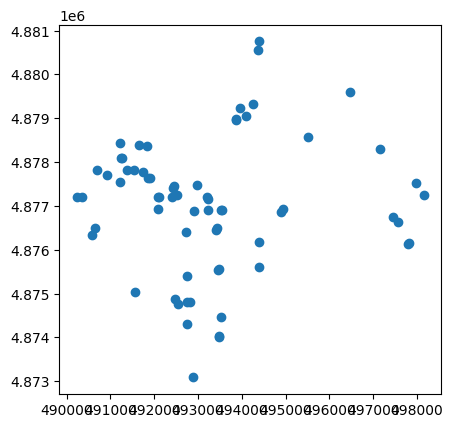

In [67]:
uo_grocery.plot()

### LTD

In [71]:
ltd_stops

OBJECTID stop_numbe  geo_node_i  \
0            1      00001         1.0   
1            2      00002         2.0   
2            3      00004         4.0   
3            4      00006         5.0   
4            5      00007         6.0   
5            6      00008         7.0   
6            7      00009         8.0   
7            8      00010         9.0   
8            9      00011        10.0   
9           10      00012        11.0   
10          11      00014        13.0   
11          12      00015        14.0   
12          13      00016        15.0   
13          14      00017        16.0   
14          15      00018        17.0   
15          16      00019        18.0   
16          17      00020        19.0   
17          18      00021        20.0   
18          19      00023        22.0   
19          20      00024        23.0   
20          21      00025        24.0   
21          22      00026        25.0   
22          23      00028        27.0   
23          24      00029        28.0   
24          25      00030        29.0   
25          26      00032        31.0   
26          27      00033        32.0   
27          28      00035        34.0   
28          29      00036        35.0   
29          30      00037        36.0   
30          31      00038        37.0   
31          32      00039        38.0   
32          33      00040        39.0   
33          34      00041        40.0   
34          35      00042        41.0   
35          36      00043        42.0   
36          37      00044        43.0   
37          38      00045        44.0   
38          39      00046        45.0   
39          40      00047        46.0   
40          41      00048        47.0   
41          42      00049        48.0   
42          43      00050        49.0   
43          44      00051        50.0   
44          45      00052        51.0   
45          46      00053        52.0   
46          47      00054        53.0   
47          48      00055        54.0   
48          49      00056        55.0   
49          50      00057        56.0   
50          51      00058        57.0   
51          52      00059        58.0   
52          53      00060        59.0   
53          54      00061        60.0   
54          55      00062        61.0   
55          56      00066        64.0   
56          57      00068        66.0   
57          58      00069        67.0   
58          59      00083        69.0   
59          60      00084        70.0   
60          61      00091        75.0   
61          62      00092        76.0   
62          63      00093        77.0   
63          64      00094        78.0   
64          65      00127        91.0   
65          66      00129        93.0   
66          67      00131        95.0   
67          68      00140        97.0   
68          69      00143        98.0   
69          70      00144        99.0   
70          71      00145       100.0   
71          72      00146       101.0   
72          73      00147       102.0   
73          74      00160       104.0   
74          75      00162       106.0   
75          76      00164       108.0   
76          77      00166       110.0   
77          78      00167       111.0   
78          79      00168       112.0   
79          80      00169       113.0   
80          81      00170       114.0   
81          82      00171       115.0   
82          83      00172       116.0   
83          84      00173       117.0   
84          85      00174       118.0   
85          86      00175       119.0   
86          87      00176       120.0   
87          88      00177       121.0   
88          89      00178       122.0   
89          90      00179       123.0   
90          91      00180       124.0   
91          92      00181       125.0   
92          93      00182       126.0   
93          94      00183       127.0   
94          95      00184       128.0   
95          96      00185       129.0   
96          97      00186    

In [86]:
ltd_stops.crs
ltd_stops_reproject = ltd_stops.to_crs('EPSG:32610')
ltd_stops_reproject.crs

<Derived Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [88]:
ltd_stops_reproject

OBJECTID stop_numbe  geo_node_i  \
0            1      00001         1.0   
1            2      00002         2.0   
2            3      00004         4.0   
3            4      00006         5.0   
4            5      00007         6.0   
5            6      00008         7.0   
6            7      00009         8.0   
7            8      00010         9.0   
8            9      00011        10.0   
9           10      00012        11.0   
10          11      00014        13.0   
11          12      00015        14.0   
12          13      00016        15.0   
13          14      00017        16.0   
14          15      00018        17.0   
15          16      00019        18.0   
16          17      00020        19.0   
17          18      00021        20.0   
18          19      00023        22.0   
19          20      00024        23.0   
20          21      00025        24.0   
21          22      00026        25.0   
22          23      00028        27.0   
23          24      00029        28.0   
24          25      00030        29.0   
25          26      00032        31.0   
26          27      00033        32.0   
27          28      00035        34.0   
28          29      00036        35.0   
29          30      00037        36.0   
30          31      00038        37.0   
31          32      00039        38.0   
32          33      00040        39.0   
33          34      00041        40.0   
34          35      00042        41.0   
35          36      00043        42.0   
36          37      00044        43.0   
37          38      00045        44.0   
38          39      00046        45.0   
39          40      00047        46.0   
40          41      00048        47.0   
41          42      00049        48.0   
42          43      00050        49.0   
43          44      00051        50.0   
44          45      00052        51.0   
45          46      00053        52.0   
46          47      00054        53.0   
47          48      00055        54.0   
48          49      00056        55.0   
49          50      00057        56.0   
50          51      00058        57.0   
51          52      00059        58.0   
52          53      00060        59.0   
53          54      00061        60.0   
54          55      00062        61.0   
55          56      00066        64.0   
56          57      00068        66.0   
57          58      00069        67.0   
58          59      00083        69.0   
59          60      00084        70.0   
60          61      00091        75.0   
61          62      00092        76.0   
62          63      00093        77.0   
63          64      00094        78.0   
64          65      00127        91.0   
65          66      00129        93.0   
66          67      00131        95.0   
67          68      00140        97.0   
68          69      00143        98.0   
69          70      00144        99.0   
70          71      00145       100.0   
71          72      00146       101.0   
72          73      00147       102.0   
73          74      00160       104.0   
74          75      00162       106.0   
75          76      00164       108.0   
76          77      00166       110.0   
77          78      00167       111.0   
78          79      00168       112.0   
79          80      00169       113.0   
80          81      00170       114.0   
81          82      00171       115.0   
82          83      00172       116.0   
83          84      00173       117.0   
84          85      00174       118.0   
85          86      00175       119.0   
86          87      00176       120.0   
87          88      00177       121.0   
88          89      00178       122.0   
89          90      00179       123.0   
90          91      00180       124.0   
91          92      00181       125.0   
92          93      00182       126.0   
93          94      00183       127.0   
94          95      00184       128.0   
95          96      00185       129.0   
96          97      00186    

### Buffer - Bus stops within 1 mile of the UO

In [77]:
uo_pd_df = pd.DataFrame({'lat': [-123.0726], 'long': [44.0448]})

In [78]:
uo

lat     long
0 -123.0726  44.0448

In [79]:
uo_gpd_gdf = gpd.GeoDataFrame(uo_pd_df, geometry = gpd.points_from_xy(uo_pd_df.lat, uo_pd_df.long))

In [80]:
uo_gpd_gdf

lat     long                     geometry
0 -123.0726  44.0448  POINT (-123.07260 44.04480)

In [81]:
uo_gpd_gdf = uo_gpd_gdf.set_crs('EPSG:4326')

In [82]:
uo_gpd_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [83]:
uo_gpd_gdf_reproject = uo_gpd_gdf.to_crs('EPSG:32610')
uo_gpd_gdf_reproject.crs

<Derived Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [84]:
uo_gpd_gdf_reproject['geometry'] = uo_gpd_gdf_reproject.geometry.buffer(4000)

In [87]:
uo_gpd_gdf_reproject

lat     long                                           geometry
0 -123.0726  44.0448  POLYGON ((498183.741 4876851.259, 498164.480 4...

In [89]:
uo_ltd = gpd.sjoin(ltd_stops_reproject, uo_gpd_gdf_reproject)

In [90]:
uo_ltd

OBJECTID stop_numbe  geo_node_i  \
49          50      00057        56.0   
58          59      00083        69.0   
59          60      00084        70.0   
88          89      00178       122.0   
89          90      00179       123.0   
90          91      00180       124.0   
91          92      00181       125.0   
92          93      00182       126.0   
93          94      00183       127.0   
94          95      00184       128.0   
95          96      00185       129.0   
118        119      00242       177.0   
119        120      00243       178.0   
120        121      00244       179.0   
121        122      00245       180.0   
123        124      00250       185.0   
124        125      00251       186.0   
125        126      00252       187.0   
126        127      00253       188.0   
127        128      00254       189.0   
128        129      00255       190.0   
129        130      00256       191.0   
130        131      00257       192.0   
131        132      00258       193.0   
132        133      00259       194.0   
133        134      00260       195.0   
134        135      00261       196.0   
135        136      00265       197.0   
136        137      00266       198.0   
137        138      00267       199.0   
138        139      00268       200.0   
139        140      00269       201.0   
140        141      00270       202.0   
141        142      00271       203.0   
142        143      00272       204.0   
143        144      00273       205.0   
144        145      00274       206.0   
157        158      00323       227.0   
158        159      00324       228.0   
159        160      00328       229.0   
160        161      00339       235.0   
161        162      00341       236.0   
162        163      00346       241.0   
163        164      00351       245.0   
164        165      00352       246.0   
165        166      00353       247.0   
166        167      00354       248.0   
167        168      00355       249.0   
168        169      00356       250.0   
169        170      00357       251.0   
170        171      00358       252.0   
171        172      00359       253.0   
172        173      00360       254.0   
184        185      00373       267.0   
185        186      00374       268.0   
186        187      00375       269.0   
187        188      00376       270.0   
188        189      00377       271.0   
189        190      00378       272.0   
190        191      00381       275.0   
191        192      00382       276.0   
216        217      00411       303.0   
217        218      00412       304.0   
218        219      00413       305.0   
219        220      00414       306.0   
220        221      00415       307.0   
221        222      00416       308.0   
222        223      00417       309.0   
223        224      00418       310.0   
224        225      00419       311.0   
225        226      00420       312.0   
226        227      00421       313.0   
227        228      00422       314.0   
228        229      00423       315.0   
229        230      00424       316.0   
230        231      00425       317.0   
231        232      00426       318.0   
232        233      00427       319.0   
233        234      00428       320.0   
234        235      00429       321.0   
252        253      00477       355.0   
253        254      00478       356.0   
254        255      00479       357.0   
255        256      00481       358.0   
256        257      00482       359.0   
257        258      00483       360.0   
258        259      00484       361.0   
259        260      00486       362.0   
260        261      00487       363.0   
261        262      00488       364.0   
262        263      00490       365.0   
263        264      00491       366.0   
264        265      00492       367.0   
265        266      00493       368.0   
266        267      00494       369.0   
267        268      00495       370.0   
268        269      00496    

<AxesSubplot: >

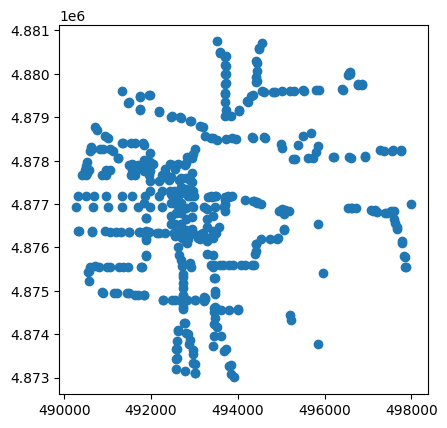

In [125]:
uo_ltd.plot()

### Plots

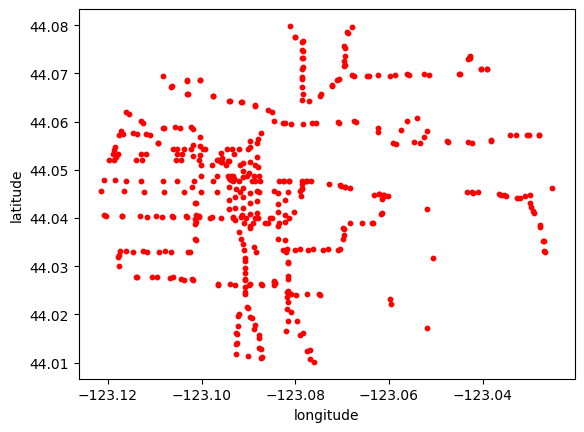

In [94]:
ax1 = uo_ltd.plot.scatter(x="longitude", y="latitude", s=10, color='red')

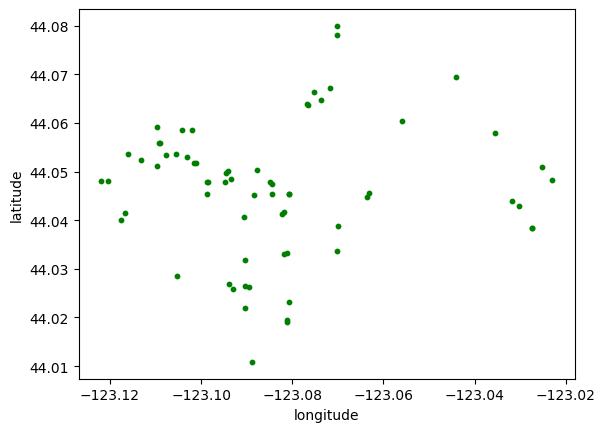

In [98]:
ax2 = uo_grocery.plot.scatter(x="longitude", y="latitude", s=10, color='green')

In [105]:
uo_ltd.plot(ax=ax2, color='none', edgecolor='black')

<AxesSubplot: >

<Figure size 640x480 with 0 Axes>

## Graph

In [106]:
G = nx.Graph()

In [110]:
G

In [113]:
uo_grocery['centroid'] = uo_grocery['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

uo_ltd['centroid'] = uo_ltd['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

In [117]:
G.graph['crs'] = 'EPSG:32610'

In [163]:
for i, row in uo_grocery.iterrows():
    G.add_node(row['concat_add'], pos=(row['longitude'], row['latitude']))
for i, row in uo_ltd.iterrows():
    G.add_node(row['geo_node_i'], pos=(row['longitude'], row['latitude']))

In [141]:
uo_grocery_df = pd.DataFrame(uo_grocery)

In [143]:
uo_ltd_df = pd.DataFrame(uo_ltd)

In [144]:
uo_ltd_df

OBJECTID stop_numbe  geo_node_i  \
49          50      00057        56.0   
58          59      00083        69.0   
59          60      00084        70.0   
88          89      00178       122.0   
89          90      00179       123.0   
90          91      00180       124.0   
91          92      00181       125.0   
92          93      00182       126.0   
93          94      00183       127.0   
94          95      00184       128.0   
95          96      00185       129.0   
118        119      00242       177.0   
119        120      00243       178.0   
120        121      00244       179.0   
121        122      00245       180.0   
123        124      00250       185.0   
124        125      00251       186.0   
125        126      00252       187.0   
126        127      00253       188.0   
127        128      00254       189.0   
128        129      00255       190.0   
129        130      00256       191.0   
130        131      00257       192.0   
131        132      00258       193.0   
132        133      00259       194.0   
133        134      00260       195.0   
134        135      00261       196.0   
135        136      00265       197.0   
136        137      00266       198.0   
137        138      00267       199.0   
138        139      00268       200.0   
139        140      00269       201.0   
140        141      00270       202.0   
141        142      00271       203.0   
142        143      00272       204.0   
143        144      00273       205.0   
144        145      00274       206.0   
157        158      00323       227.0   
158        159      00324       228.0   
159        160      00328       229.0   
160        161      00339       235.0   
161        162      00341       236.0   
162        163      00346       241.0   
163        164      00351       245.0   
164        165      00352       246.0   
165        166      00353       247.0   
166        167      00354       248.0   
167        168      00355       249.0   
168        169      00356       250.0   
169        170      00357       251.0   
170        171      00358       252.0   
171        172      00359       253.0   
172        173      00360       254.0   
184        185      00373       267.0   
185        186      00374       268.0   
186        187      00375       269.0   
187        188      00376       270.0   
188        189      00377       271.0   
189        190      00378       272.0   
190        191      00381       275.0   
191        192      00382       276.0   
216        217      00411       303.0   
217        218      00412       304.0   
218        219      00413       305.0   
219        220      00414       306.0   
220        221      00415       307.0   
221        222      00416       308.0   
222        223      00417       309.0   
223        224      00418       310.0   
224        225      00419       311.0   
225        226      00420       312.0   
226        227      00421       313.0   
227        228      00422       314.0   
228        229      00423       315.0   
229        230      00424       316.0   
230        231      00425       317.0   
231        232      00426       318.0   
232        233      00427       319.0   
233        234      00428       320.0   
234        235      00429       321.0   
252        253      00477       355.0   
253        254      00478       356.0   
254        255      00479       357.0   
255        256      00481       358.0   
256        257      00482       359.0   
257        258      00483       360.0   
258        259      00484       361.0   
259        260      00486       362.0   
260        261      00487       363.0   
261        262      00488       364.0   
262        263      00490       365.0   
263        264      00491       366.0   
264        265      00492       367.0   
265        266      00493       368.0   
266        267      00494       369.0   
267        268      00495       370.0   
268        269      00496    

In [145]:
uo_grocery_df

OBJECTID  geofeat_id            concat_add  house_nbr  house_suff  \
93      66837       84933        1131 W 1ST AVE       1131         NaN   
94      67241       79712      357 VAN BUREN ST        357         NaN   
95      67268       22056        385 BLAIR BLVD        385         NaN   
96      68250       86330        1525 W 6TH AVE       1525         NaN   
97      68471       87204        1101 W 8TH AVE       1101         NaN   
100     69102       86676        1333 W 7TH AVE       1333         NaN   
104     70611       88212       1915 W 11TH AVE       1915         NaN   
105     70622       88204       1815 W 11TH AVE       1815         NaN   
107     73314       92612       1675 W 18TH AVE       1675         NaN   
111     82738       29049        1500 COBURG RD       1500         NaN   
112     82949       82589   2580 WILLAKENZIE RD       2580         NaN   
119     88757      126582        1191 HARLOW RD       1191         NaN   
121     91216       28802         445 COBURG RD        445         NaN   
122     91706       62856      85 OAKWAY CENTER         85         NaN   
124     93309       28777         311 COBURG RD        311         NaN   
126     94054       28768         201 COBURG RD        201         NaN   
128     95874     1004672        117 COMMONS DR        117         NaN   
131     96001       59895         111 MONROE ST        111         NaN   
132     98547      129892            701 W M ST        701         NaN   
135    101075       86134         951 W 6TH AVE        951         NaN   
137    102829       86437       544 W 7TH AVE 1        544         NaN   
139    103346       86129         849 W 6TH AVE        849         NaN   
140    104308       86439         588 W 7TH AVE        588         NaN   
141    104528       23706       99 W BROADWAY C         99         NaN   
142    105349       23709        110 W BROADWAY        110         NaN   
143    105573      122835               30 E ST         30         NaN   
144    106462       87446         66 W 10TH AVE         66         NaN   
145    106944       87940        395 W 11TH AVE        395         NaN   
146    106947       87938        391 W 11TH AVE        391         NaN   
147    107985       87879        536 E 11TH AVE        536         NaN   
148    108280      118429              220 B ST        220         NaN   
149    109266       89419        410 W 13TH AVE        410         NaN   
150    109428       87918        125 W 11TH AVE        125         NaN   
151    109492       87862        503 E 11TH AVE        503         NaN   
152    109722       15834       1316 ALDER ST 1       1316         NaN   
153    109765       89258        544 E 13TH AVE        544         NaN   
154    110096       89194        296 E 13TH AVE        296         NaN   
155    110232       39025  2001 FRANKLIN BLVD 1       2001         NaN   
160    111958       39022    1960 FRANKLIN BLVD       1960         NaN   
164    113562       39147    4215 FRANKLIN BLVD       4215         NaN   
165    114202     1010163       1659 HILYARD ST       1659         NaN   
166    114587       39171    4430 FRANKLIN BLVD       4430         NaN   
167    114693       46731       1698 HILYARD ST       1698         NaN   
168    115581       92108        145 E 18TH AVE        145         NaN   
182    124546       92618       1690 W 18TH AVE       1690         NaN   
185    133832       39524    4791 FRANKLIN BLVD       4791         NaN   
186    134091       93417       1490 E 19TH AVE       1490         NaN   
187    135558       39525  4791 FRANKLIN BLVD 1       4791         NaN   
188    136817       83213    2489 WILLAMETTE ST       2489         NaN   
189    136962       15590         2390 AGATE ST       2390         NaN   
190    136978       94367        748 E 24TH AVE        748         NaN   
191    137054       46811       2429 HILYARD ST       2429         NaN   
192    137430       39861      2757 FRIENDLY ST       2757         NaN   
193    13

In [147]:
target_xy = [uo_grocery['centroid'].y.values, uo_grocery['centroid'].x.values]

In [167]:
pip install geopy 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.4 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [168]:
import geopy.distance

In [182]:
for i, stop in uo_ltd.iterrows():
    for j, store in uo_grocery.iterrows():
        stop_pos = stop["latitude"], stop["longitude"]
        store_pos = store["latitude"], store["longitude"]
        distance = geopy.distance.distance(stop_pos, store_pos).miles

## Visualization

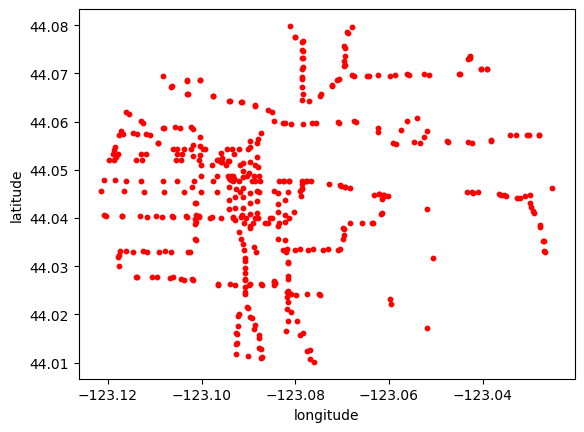

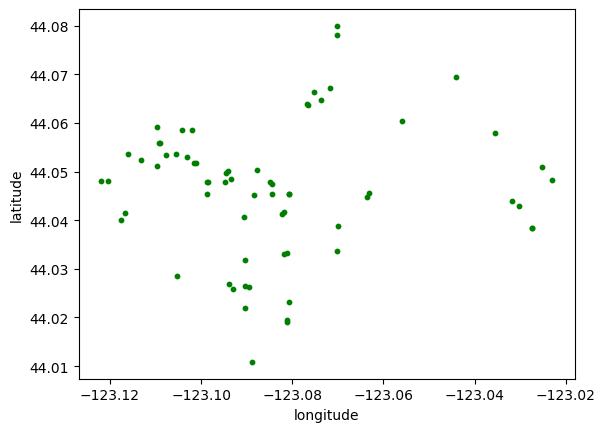

In [188]:
ax = uo_ltd.plot.scatter(x="longitude", y="latitude", s=10, color='red') and uo_grocery.plot.scatter(x="longitude", y="latitude", s=10, color='green')

In [196]:
ax.scatter(x=uo_ltd["longitude"], y=uo_ltd["latitude"], s=10, color='red')

In [202]:
ax.scatter(x=uo_ltd["longitude"], y=uo_ltd["latitude"], s=10, color='red')
plt.show()

In [211]:
import contextily as ctx

In [213]:
print(uo_grocery.shape)

(67, 53)


In [214]:
print(uo_ltd.shape)

(472, 11)


## Isochrone map

In [259]:
trip_times = [5, 10, 15, 20, 25] 

In [260]:
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

In [261]:
G.graph['crs']

'EPSG:32610'

In [262]:
gr = ox.graph_from_place('Eugene, Oregon, USA')

In [263]:
gr.graph['crs'] = 'EPSG:32610'

In [264]:
graph_proj = ox.project_graph(gr, to_crs='EPSG:32610')

In [265]:
orig_xy = uo_ltd_df['centroid'].to_numpy().T.tolist()

In [266]:
target_xy = uo_grocery['centroid'].apply(lambda point: (point.y, point.x)).tolist()

In [267]:
print(type(orig_xy))

<class 'list'>


In [268]:
print(type(orig_xy[0]))
print(type(orig_xy[1]))

<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>


In [269]:
orig_nodes = []
for point in orig_xy:
    x, y = point.x, point.y
    assert isinstance(x, float) and not np.isnan(x)
    assert isinstance(y, float) and not np.isnan(y)
    node = ox.distance.nearest_nodes(graph_proj, X=x, Y=y, return_dist=False)
    orig_nodes.append(node)

In [270]:
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(graph_proj, orig_nodes[0], radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color

In [272]:
nc = [node_colors[node] if node in node_colors else "none" for node in graph_proj.nodes()]
ns = [10 if node in node_colors else 0 for node in graph_proj.nodes()]

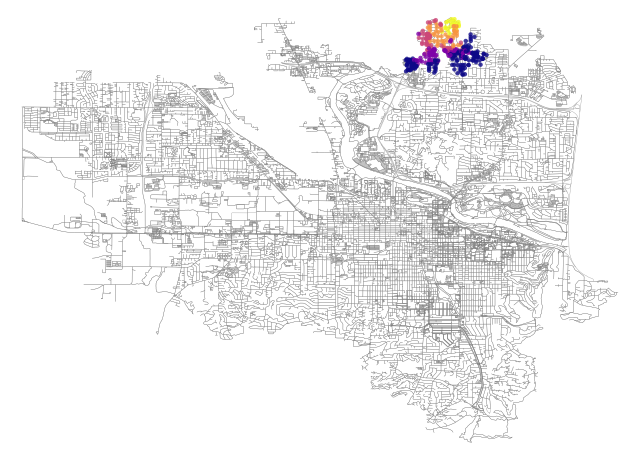

In [273]:
fig, ax = ox.plot_graph(graph_proj, node_color=nc, node_size=ns, node_alpha=0.8,
    edge_linewidth=0.2, edge_color="grey", bgcolor='white')

# Part 2

In [274]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt

In [351]:
uo_ltd.head()

OBJECTID stop_numbe  geo_node_i                        stop_name  \
49        50      00057        56.0            N/S of Main W of Mill   
58        59      00083        69.0  N/S of Harlow Road W of Beverly   
59        60      00084        70.0    S/S of Harlow Rd W of Beverly   
88        89      00178       122.0  N/S of Centennial W of Prescott   
89        90      00179       123.0  S/S of Centennial E of Prescott   

     latitude   longitude                        geometry  index_right  \
49  44.046195 -123.025122  POINT (497987.397 4877003.901)            0   
58  44.069946 -123.045044  POINT (496392.915 4879642.590)            0   
59  44.069834 -123.044771  POINT (496414.746 4879630.205)            0   
88  44.057254 -123.034035  POINT (497273.867 4878232.489)            0   
89  44.057195 -123.032894  POINT (497365.256 4878225.932)            0   

         lat     long                        centroid  
49 -123.0726  44.0448  POINT (497987.397 4877003.901)  
58 -123.0726  44.0448  POINT (496392.915 4879642.590)  
59 -123.0726  44.0448  POINT (496414.746 4879630.205)  
88 -123.0726  44.0448  POINT (497273.867 4878232.489)  
89 -123.0726  44.0448  POINT (497365.256 4878225.932)

In [350]:
uo_grocery.head()

OBJECTID  geofeat_id        concat_add  house_nbr  house_suff pre_direct  \
93     66837       84933    1131 W 1ST AVE       1131         NaN          W   
94     67241       79712  357 VAN BUREN ST        357         NaN        NaN   
95     67268       22056    385 BLAIR BLVD        385         NaN        NaN   
96     68250       86330    1525 W 6TH AVE       1525         NaN          W   
97     68471       87204    1101 W 8TH AVE       1101         NaN          W   

   street_nam street_typ unit_type_ unit_id city_name_ city_name five_digit  \
93        1ST        AVE        NaN     NaN        EUG    Eugene      97402   
94  VAN BUREN         ST        NaN     NaN        EUG    Eugene      97402   
95      BLAIR       BLVD        NaN     NaN        EUG    Eugene      97402   
96        6TH        AVE        NaN     NaN        EUG    Eugene      97402   
97        8TH        AVE        NaN     NaN        EUG    Eugene      97402   

   four_digit  initial_cr  last_updat      maptaxlot mapnumber taxlot  \
93       4907  1986-09-24  2017-04-26  1704254102901  17042541  02901   
94       4945  1985-05-01  2014-12-24  1704254402700  17042544  02700   
95        NaN  1983-08-07  2014-12-24  1704254402800  17042544  02800   
96        NaN  1986-09-24  2016-06-15  1704361204700  17043612  04700   
97       4862  1986-09-24         NaN  1704361115400  17043611  15400   

    account geocity annexhist  ugb neighbor plandesdes landuse usecode  \
93  1131919     EUG       NaN  EUG        5        NaN    5410       R   
94   444230     EUG       NaN  EUG        5        NaN    5410       R   
95   444248     EUG       NaN  EUG        5        NaN    5410       R   
96   474377     EUG       NaN  EUG        5        NaN    5410       R   
97   473775     EUG       NaN  EUG       24        NaN    5410       R   

   firedist electionpr ccward cocommdist strepdist senatedist lcczone  \
93      EGF       1783     E7          3        13          7       5   
94      EGF       1783     E7          3        13          7       5   
95      EGF       1783     E7          3        13          7       5   
96      EGF       1783     E7          3        13          7       5   
97      EGF       1123     E1          3        13          7       5   

   schooldist  elem middle high ltddist blockgr ctract    x_coordina  \
93         4J   525    518  536       Y       2   4000  4.235315e+06   
94         4J   525    518  536       Y       3   4200  4.235383e+06   
95         4J   525    518  536       Y       3   4200  4.235432e+06   
96         4J   525    518  536       Y       2   4200  4.233591e+06   
97         4J  4146   4554  540       Y       3   4502  4.235224e+06   

       y_coordina   latitude   longitude psap_code          psap_name  \
93  882651.713583  44.059135 -123.109705        CL  CENTRAL LANE PSAP   
94  881479.739501  44.055928 -123.109309        CL  CENTRAL LANE PSAP   
95  881470.660433  44.055907 -123.109121        CL  CENTRAL LANE PSAP   
96  880676.652887  44.053573 -123.116025        CL  CENTRAL LANE PSAP   
97  879729.670932  44.051116 -123.109707        CL  CENTRAL LANE PSAP   

    trans_anal                        geometry  index_right       lat  \
93         253  POINT (491212.082 4878447.346)            0 -123.0726   
94         254  POINT (491243.367 4878091.051)            0 -123.0726   
95         254  POINT (491258.411 4878088.732)            0 -123.0726   
96         261  POINT (490705.041 4877830.199)            0 -123.0726   
97         258  POINT (491210.731 4877556.639)            0 -123.0726   

       long                        centroid  
93  44.0448  POINT (491212.082 4878447.346)  
94  44.0448  POINT (491243.367 4878091.051)  
95  44.0448  POINT (491258.411 4878088.732)  
96  44.0448  POINT (490705.041 4877830.199)  
97  44.0448  POINT (491210.731 4877556.639)

In [280]:
graph = ox.graph_from_place('Eugene, Oregon', network_type='all')

In [281]:
graph2 = nx.Graph(graph)

In [285]:
for idx, row in uo_ltd.iterrows():
    x, y = row.geometry.coords[0]
    node = ox.distance.nearest_nodes(graph, x, y)
    graph2.add_node(node, x=x, y=y)

In [286]:
for idx, row in uo_grocery.iterrows():
    x, y = row.geometry.coords[0]
    node = ox.distance.nearest_nodes(graph, x, y)
    graph2.add_node(node, x=x, y=y)

In [287]:
for u, v, k in graph.edges(keys=True):
    x1, y1 = graph.nodes[u]['x'], graph.nodes[u]['y']
    x2, y2 = graph.nodes[v]['x'], graph.nodes[v]['y']
    graph2.add_edge(u, v, weight=ox.distance.euclidean_dist_vec(y1, x1, y2, x2))


In [289]:
uo_ltd_1 = ox.distance.nearest_nodes(graph, uo_ltd['geometry'].x, uo_ltd['geometry'].y)
uo_grocery_1 = ox.distance.nearest_nodes(graph, uo_grocery['geometry'].x, uo_grocery['geometry'].y)

In [ ]:
fig, ax = ox.plot_graph(graph2, node_size=0, edge_color='lightgray', bgcolor='w', show=False, close=False)
ax.scatter(uo_ltd_1['geometry'].x, uo_ltd_1['geometry'].y, color='red', zorder=2)
ax.scatter(uo_grocery_1['geometry'].x, uo_grocery_1['geometry'].y, color='green', zorder=2)
nx.draw_networkx_edges(graph2, nx.get_node_attributes(graph2, 'pos'), edgelist=path, edge_color='b', width=2)
plt.show()

## Try 2

In [298]:
place_name = 'University of Oregon, Eugene, OR'

In [299]:
dist = 4023.36

In [300]:
graph3 = ox.graph_from_address(place_name, network_type='all', dist=dist, dist_type='bbox')

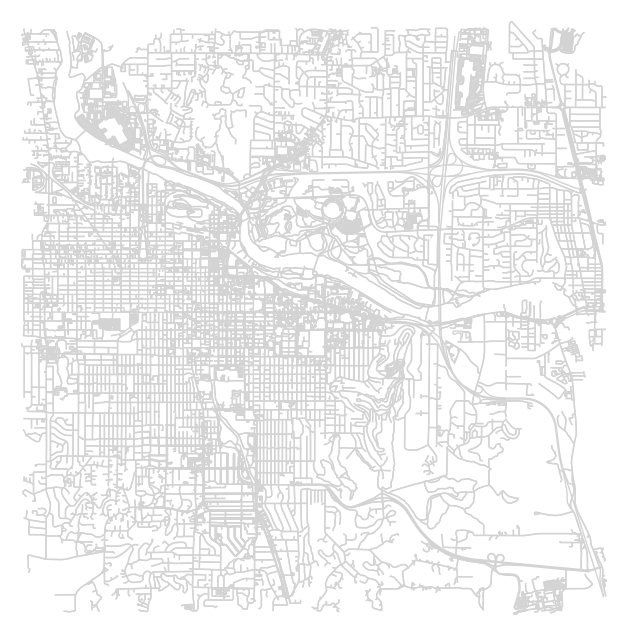

In [301]:
fig, ax = ox.plot_graph(graph3, node_size=0, edge_color='lightgray', bgcolor='w', show=False, close=False)

In [313]:
uo_ltd_nodes = []
for idx, row in uo_ltd.iterrows():
    node = ox.distance.nearest_nodes(graph3, row['geometry'].x, row['geometry'].y, return_dist=False)
    uo_ltd_nodes.append(node)

In [314]:
uo_grocery_nodes = []
for idx, row in uo_grocery.iterrows():
    node = ox.distance.nearest_nodes(graph3, row['geometry'].x, row['geometry'].y, return_dist=False)
    uo_grocery_nodes.append(node)

In [337]:
shortest_paths = []
for i in range(len(uo_ltd_nodes)):
    for j in range(len(uo_grocery_nodes)):
        path = nx.shortest_path(graph3, source=uo_ltd_nodes[i], target=uo_grocery_nodes[j], weight='length')
        shortest_paths.append(path)

In [320]:
place_name = 'University of Oregon, Eugene, OR'
dist = 4023.36
graph3 = ox.graph_from_address(place_name, network_type='all', dist=dist, dist_type='bbox')

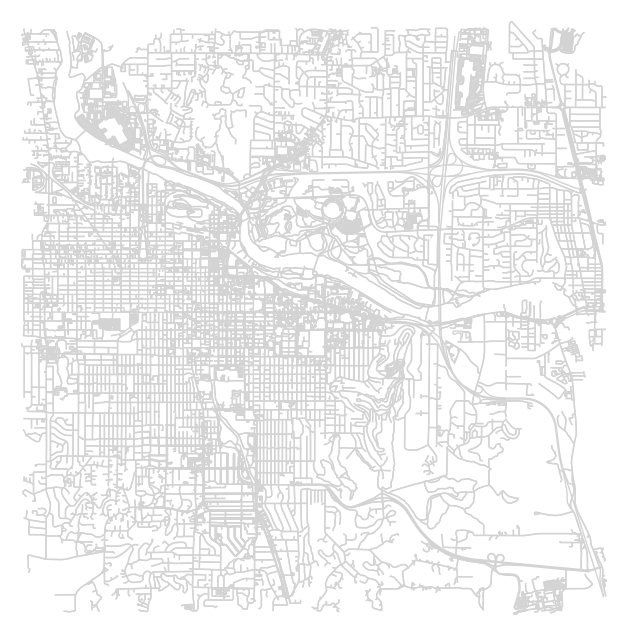

In [328]:
fig, ax = ox.plot_graph(graph3, node_size=0, edge_color='lightgray', bgcolor='w', show=False, close=False)

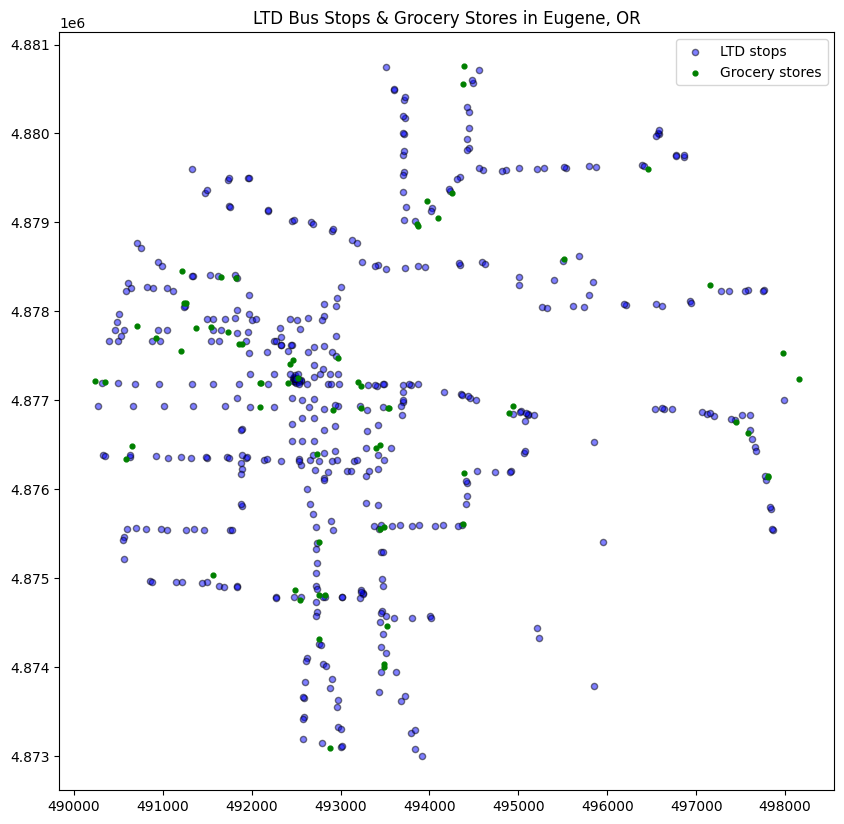

In [403]:
fig, ax = plt.subplots(figsize=(10, 10))
uo_ltd.plot(ax=ax, color='blue', markersize=20, alpha=0.5, edgecolor='k', label='LTD stops')
uo_grocery.plot(ax=ax, color='green', markersize=12, label='Grocery stores')
ax.set_title("LTD Bus Stops & Grocery Stores in Eugene, OR")
ax.legend()

In [371]:
eugUGB = gpd.read_file('Eugene_Urban_Growth_Boundary_(UGB)_-_HUB/Eugene_Urban_Growth_Boundary_(UGB)_-_HUB.shp')

<AxesSubplot: >

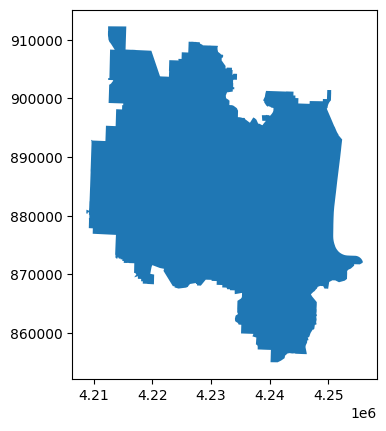

In [377]:
eugUGB.plot()

In [411]:
pip install mplleaflet


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [412]:
import mplleaflet

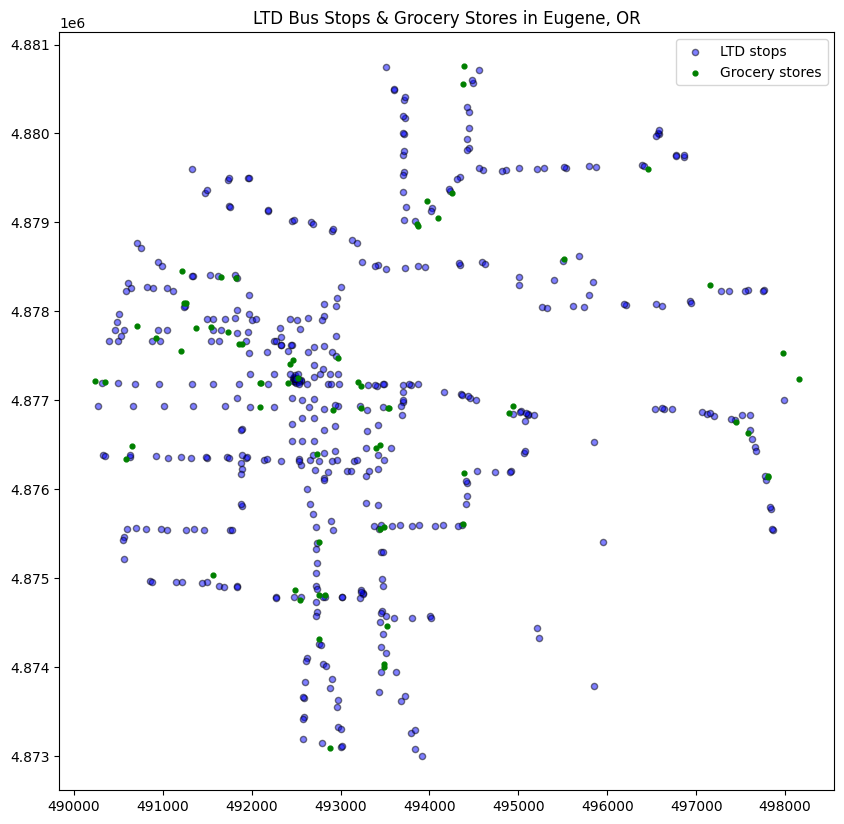

In [420]:
fig, ax = plt.subplots(figsize=(10, 10))
uo_ltd.plot(ax=ax, color='blue', markersize=20, alpha=0.5, edgecolor='k', label='LTD stops')
uo_grocery.plot(ax=ax, color='green', markersize=12, label='Grocery stores')
ax.set_title("LTD Bus Stops & Grocery Stores in Eugene, OR")
ax.legend()

In [421]:
fig.savefig('map.png', dpi=300, bbox_inches='tight')

In [423]:
pip install aprx

ERROR: Could not find a version that satisfies the requirement aprx (from versions: none)
ERROR: No matching distribution found for aprx

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
